

## BERT Classifier to detect DGA domains.
### Author: Abdulkarim Abdulkadir


In [ ]:
%pip install ktrain

     |████████████████████████████████| 25.3 MB 1.3 MB/s 
     |████████████████████████████████| 6.8 MB 29.8 MB/s 
     |████████████████████████████████| 981 kB 58.6 MB/s 
     |████████████████████████████████| 263 kB 52.5 MB/s 
     |████████████████████████████████| 2.8 MB 50.7 MB/s 
     |████████████████████████████████| 1.2 MB 63.1 MB/s 
     |████████████████████████████████| 468 kB 51.2 MB/s 
     |████████████████████████████████| 61 kB 479 kB/s 
     |████████████████████████████████| 895 kB 66.0 MB/s 
     |████████████████████████████████| 596 kB 57.3 MB/s 
     |████████████████████████████████| 3.3 MB 63.7 MB/s 
  Created wheel for ktrain: filename=ktrain-0.28.3-py3-none-any.whl size=25292659 sha256=5c9d7a1d8c888f855e58bedfb6fb93d016d2831e67b2f20d3e37cca36fb5f3ad
  Stored in directory: /root/.cache/pip/wheels/6a/7e/c3/f46cdfc2b81c54424923b1405d7e670c35cacc11ada9a47b1c
  Created wheel for seqeval: filename=seqeval-0.0.19-py3-none-any.whl size=9929 sha256=809ae63a0b7f9fc2

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import ktrain
from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [ ]:

dgaLocation = '/content/drive/MyDrive/research/generated_domains/'
dgaDomains = [dga for dga in os.listdir(dgaLocation) if dga.endswith(r".csv")]
print("Total amount of DGA types: ", len(dgaDomains))
benignDomains = '/content/drive/MyDrive/research/benign_domains/top-1m.csv'

Total amount of DGA types:  19


In [ ]:
dataset = pd.DataFrame()
for i, dga in enumerate(dgaDomains):
    dgaDataFrame = pd.read_csv(dgaLocation + dga)
    dgaDataFrame.insert(1,'type',dga.split(".")[0])
    dgaDataFrame.insert(2,'class',1)
    dataset = dataset.append(dgaDataFrame, ignore_index=True)
datasetTrimmed = pd.DataFrame()
datasetTrimmed = shuffle(dataset)
datasetTrimmed = datasetTrimmed[:67500]
benignDataFrame = pd.read_csv(benignDomains)
benignDataFrame.insert(1, 'type', 'benign')
benignDataFrame.insert(1, 'class', 0)
datasetTrimmed = datasetTrimmed.append(shuffle(benignDataFrame[:82500]), ignore_index=True)
datasetTrimmed = shuffle(datasetTrimmed)
datasetTrimmed = datasetTrimmed.reset_index(drop=True)

In [ ]:
print("Total amount of DGA domains: ", datasetTrimmed['class'].value_counts()[1])
print("Total amount of benign domains: ", datasetTrimmed['class'].value_counts()[0])
print("Total amount of DGA domains: ", len(datasetTrimmed))
datasetTrimmed.to_csv('dataset', index=False)

Total amount of DGA domains:  67500
Total amount of benign domains:  82500
Total amount of DGA domains:  150000


In [ ]:
dataset = pd.read_csv('dataset')
X = dataset['domain']

labels = dataset['class']
class_names = labels.unique()
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    labels,
                                                    test_size=0.20,
                                                    random_state=69)

In [ ]:
print("Rows in x_train %d : " % len(x_train))
print("Rows in y_train: ", y_train.value_counts())

Rows in x_train 120000 : 
Rows in y_train:  0    65951
1    54049
Name: class, dtype: int64


In [ ]:
model_name = 'distilbert-base-uncased'
t = ktrain.text.Transformer(model_name, class_names=labels.unique(),
                     maxlen=500)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Pre-process train and test dataset
train = t.preprocess_train(x_train.tolist(), y_train.to_list())

val = t.preprocess_test(x_test.tolist(), y_test.to_list())
model = t.get_classifier()

preprocessing train...
language: en
train sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

simulating training for different learning rates... this may take a few moments...
Epoch 1/4
15000/15000 [==============================] - 4257s 281ms/step - loss: 0.1705 - accuracy: 0.9261
Epoch 2/4
15000/15000 [==============================] - 3224s 213ms/step - loss: 0.1321 - accuracy: 0.9396


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


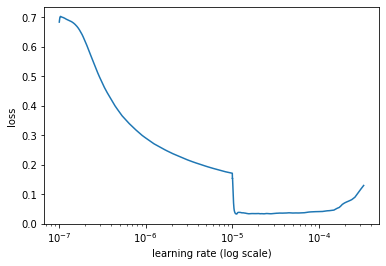

In [ ]:
learner = ktrain.get_learner(model,
                       train_data=train,
                       val_data=val,
                       batch_size=8)
learner.lr_find(max_epochs=4)
learner.lr_plot()

In [ ]:
learner.fit_onecycle(3e-5, 4)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/4
15000/15000 [==============================] - 4297s 284ms/step - loss: 0.0439 - accuracy: 0.9850 - val_loss: 0.0193 - val_accuracy: 0.9946
Epoch 2/4
15000/15000 [==============================] - 4288s 284ms/step - loss: 0.0166 - accuracy: 0.9952 - val_loss: 0.0140 - val_accuracy: 0.9964
Epoch 3/4
15000/15000 [==============================] - 4284s 284ms/step - loss: 0.0088 - accuracy: 0.9977 - val_loss: 0.0127 - val_accuracy: 0.9971
Epoch 4/4
15000/15000 [==============================] - 4285s 284ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0151 - val_accuracy: 0.9974


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t).save('model/')

In [1]:
learner.validate(val_data=(x_test, y_test), class_names=class_names)

NameError: ignored